![ecg_filter_diagram](./img/ecg_filter_diagram.png)

In [2]:
import itertools as it
import time  # for sleep
from importlib import reload
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import padasip as pa  # adaptive filter package
import pandas as pd
import scipy as sp
from IPython.display import clear_output
from tqdm import tqdm # progress bar

# from lms import lms_filter, LmsResult
from filters.LMS import Result as LmsResult
from filters.LMS import lms
from filters.utils import SNR, signaltonoise

np.random.seed(42069) # always use the same random seed to make results comparable

In [12]:
# read ecg.dat into a numpy array
ecg = np.loadtxt('./data/ecg.dat')
n_samples = ecg.size

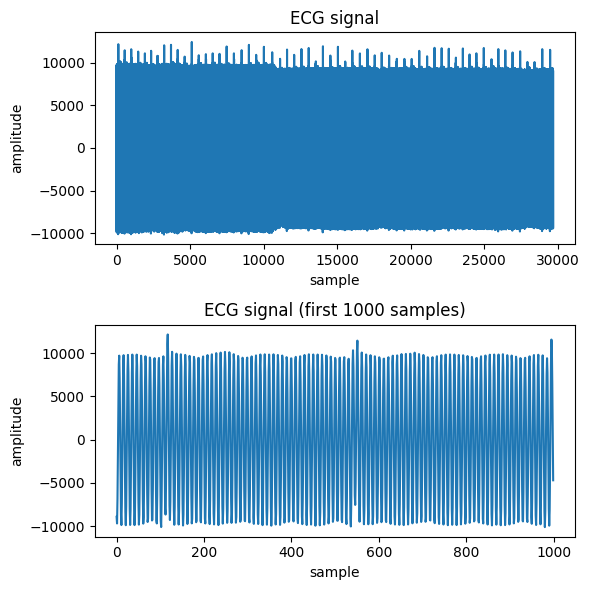

In [13]:
# plot ecg signal twice, once with the original signal and once with the first 1000 samples
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(ecg)
ax[0].set_title('ECG signal')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('amplitude')
ax[1].plot(ecg[:1000])
ax[1].set_title('ECG signal (first 1000 samples)')
ax[1].set_xlabel('sample')
ax[1].set_ylabel('amplitude')
plt.tight_layout()
plt.savefig('./img/ecg_signal.png')
plt.show()

Power line frequency: 49.56 Hz


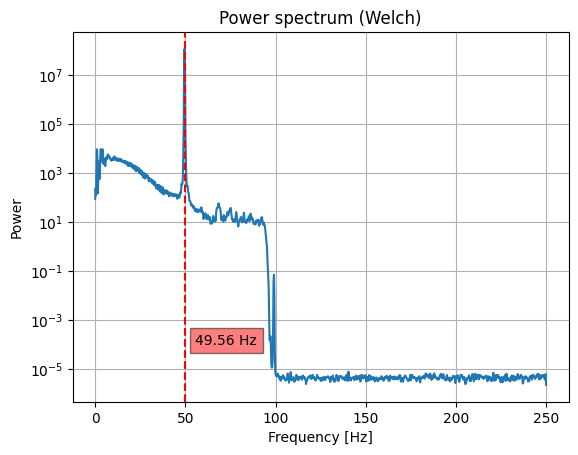

In [14]:
# find power line frequency (50 Hz)
Fs = 500 # sampling frequency
f, pxx = sp.signal.welch(ecg, Fs, nperseg=2048) # nperseg is the number of samples per segment i.e. the length of the window

max_pxx_idx: int = np.argmax(pxx)
powerline_freq: float = f[max_pxx_idx]
print(f'Power line frequency: {powerline_freq:.2f} Hz')

# plot power spectrum
plt.figure()
plt.plot(f, pxx)
plt.title('Power spectrum (Welch)')
plt.xlabel('Frequency [Hz]')
plt.yscale('log') # more meaningful scale
plt.grid()
plt.ylabel('Power')
plt.text(powerline_freq + 6, 1e-4, f'{powerline_freq:.2f} Hz', bbox=dict(facecolor='red', alpha=0.5))
plt.axvline(x=powerline_freq, color='red', linestyle='--') # mark power line frequency
plt.savefig('./img/ecg_power_spectrum.png')
plt.show()

## 2  How many filter coeffcients are needed in the adaptive filter?

We have **1** frequency (50 Hz) that we want to affect, so we need **2** taps. <br>
With 1 tap we can only affect the gain of the signal, as we only have a scalar in H(z) <br>
With 2 taps we can affect both the gain and phase of the signal, as H(z) = a + bz^-1

In [15]:
suggested_n_taps = 2

## 3  Implement an LMS filter which removes the ECG signal from a generated sinusoid at the power line frequency.

In [16]:
# input signal is cos(2*pi*50*t)
synthetic_cosine_at_powerline_freq = np.cos(2 * np.pi * powerline_freq / Fs * np.arange(n_samples))

## 4  Select an appropriate value for the step-size μ.

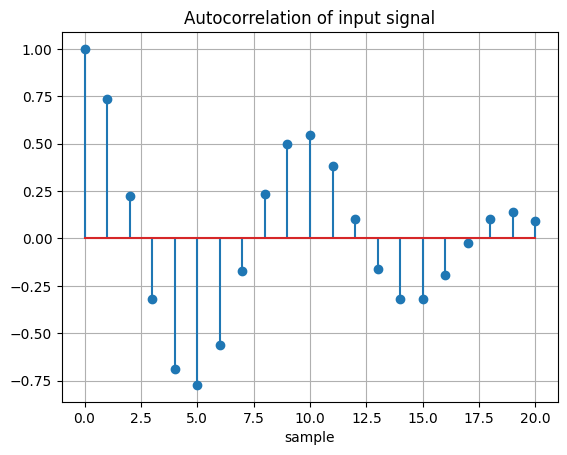

In [18]:
lags = 21

def autocorr(x: np.ndarray, order: int, lags: int = 21) -> np.ndarray:
    rx = sp.signal.correlate(x[:lags], x[:lags], mode='full')
    rx = rx[(rx.size//2):] # take only the positive lags
    rx /= rx[0] # normalize

    # toepliz matrix
    Rxx = sp.linalg.toeplitz(rx[(rx.size // 2):]) # take only the positive lags
    # see equ. 6.73 for why we slice [:ntaps, :ntaps]
    Rxx = sp.linalg.toeplitz(rx[(rx.size // 2):])[:order, :order] # take only the positive lags
    return rx, Rxx

rx, Rxx = autocorr(synthetic_cosine_at_powerline_freq, suggested_n_taps)

# plot autocorrelation of input signal
plt.figure()
plt.stem(rx)
plt.title('Autocorrelation of input signal')
plt.grid()
plt.xlabel('sample')
plt.savefig('./img/autocorrelation_of_input_signal.png')
plt.show()

![lms-stability-condition](./screenshots/stability-condition-for-lms.png)

In [8]:
trR = np.trace(Rxx)

upper_limit_for_learning_rate_with_lms = 1 / (3 * trR)
upper_limit_for_learning_rate_with_lms

print(f'0 < mu < {upper_limit_for_learning_rate_with_lms:.2f}')

0 < mu < 0.31


In [19]:
# notch filter
# Design and apply a 50 Hz notch filter.
Q = 30.0  # Quality factor
b, a = sp.signal.iirnotch(powerline_freq, Q, fs=Fs)
ecg_notch = sp.signal.filtfilt(b, a, ecg)

estimated_noise = ecg - ecg_notch

In [26]:
def plot_filtered_ecg_signal(adaptive_filter_result, xlim_intervals = [(0, n_samples), (24500, 27000), (0, 2500)], plot_loss_curve: bool = True, savefig=None) -> None:
    n_plots = len(xlim_intervals)
    n_plots += 1 if plot_loss_curve else 0

    _, ax = plt.subplots(n_plots, 1, figsize=(10, 12))

    err = adaptive_filter_result.err
    mse = adaptive_filter_result.mse

    for i, (xlim_min, xlim_max) in enumerate(xlim_intervals):
        ax[i].plot(ecg)
        ax[i].plot(err)
        ax[i].set_title(f'samples {xlim_min} to {xlim_max}')
        ax[i].set_xlabel('sample')
        ax[i].set_ylabel('amplitude')
        ax[i].set_ylim(-2000, 5000)
        ax[i].set_xlim(xlim_min, xlim_max)
        ax[i].legend(['Noisy ECG signal', 'Error signal (filtered ECG)'])
        
    # plot loss curve
    if plot_loss_curve:
        ax[n_plots - 1].plot(mse)
        ax[n_plots - 1].set_title('Loss curve')
        ax[n_plots - 1].set_xlabel('iteration')
        ax[n_plots - 1].semilogy()
        ax[n_plots - 1].set_ylabel('MSE (log scale)')
        ax[n_plots - 1].grid()

    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show()

In [27]:
mu = 0.3 # step size between 0 and 1 / (3 * trR)

lms_result: LmsResult = lms(synthetic_cosine_at_powerline_freq, ecg, mu, suggested_n_taps)
y = lms_result.y
err = lms_result.err


##  5 Examine the error-signal e(k) by plotting it and comparing it with the original noisy ECG-signal.

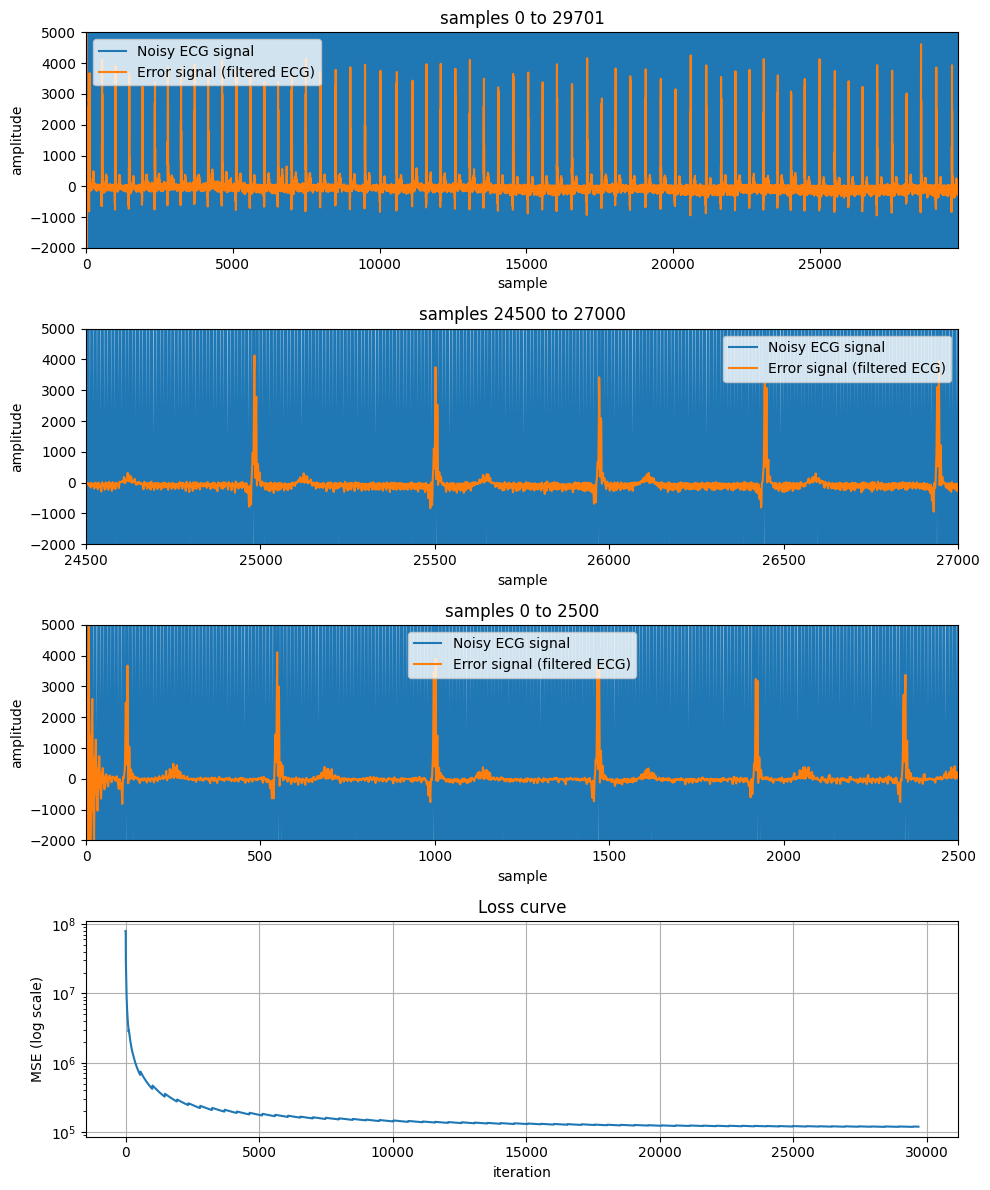

In [28]:
plot_filtered_ecg_signal(lms_result, savefig='./img/lms_filtered_ecg_signal_taps_2_mu_0.3.png')

In [29]:
def plot_weights_over_time_and_against_each_other(adaptive_filter_result, figsize=(6,6), savefig=None) -> None:
    w = adaptive_filter_result.weights

    _, ax = plt.subplots(2, 1, figsize=figsize)
    ax[0].plot(w)
    ax[0].set_title('Weights over time')
    ax[0].set_xlabel('sample')
    ax[0].set_ylabel('weight')
    ax[0].grid()

    viridis = plt.get_cmap('viridis')
    ax[1].scatter(w[:, 0], w[:, 1], cmap=viridis,s=1)
    ax[1].set_title('Weights against each other')
    ax[1].set_xlabel('weight 1')
    ax[1].set_ylabel('weight 2')
    ax[1].grid()

    if savefig:
        plt.savefig(savefig)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_8799/1294600897.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1].scatter(w[:, 0], w[:, 1], cmap=viridis,s=1)


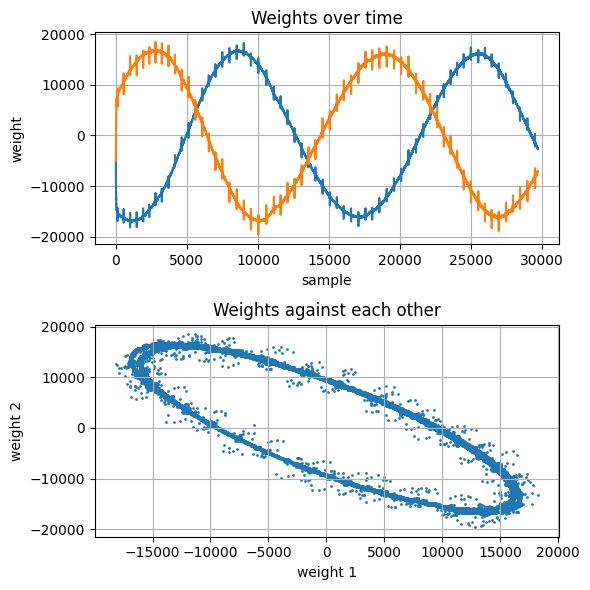

In [30]:
plot_weights_over_time_and_against_each_other(lms_result, savefig='./img/lms_weights_over_time_and_against_each_other_taps_2_mu_0.3.png')

## 6  Adjust your parameters μ and the number of filter coefficients and see how good results you can acheive. If possible, estimate the improvement in signal-to-noise ratio.

In [32]:
snrs = []

# test 2,3, ..., 8 taps
for taps in tqdm(range(2, 8 + 1), ncols=100):
    _, Rxx = autocorr(synthetic_cosine_at_powerline_freq, taps)

    mu = 1 / (3 * np.trace(Rxx)) # estimate mu from Rxx
    
    for mu_ in np.linspace(0 , mu, 5)[1:]: # skip mu = 0
        result: LmsResult = lms(synthetic_cosine_at_powerline_freq, ecg, mu_, taps)
        err = result.err
        # snr = SNR(err, ecg[:-(taps - 1)] - err)
        snr = SNR(err , estimated_noise)

        snrs.append((taps, mu_, snr, result.mse[-1]))
        print(snrs[-1])

  0%|                                                                         | 0/7 [00:00<?, ?it/s]

(2, 0.07645907191841042, -24.701463663807488, 151803.29575693136)
(2, 0.15291814383682084, -25.405081018986667, 129097.4592553184)
(2, 0.22937721575523126, -25.61501555543202, 123004.76966279466)


 14%|█████████▎                                                       | 1/7 [00:04<00:27,  4.65s/it]

(2, 0.3058362876736417, -25.74482177930126, 119382.21010181116)
(3, 0.050972714612273616, -25.45598925513047, 127597.66658728186)
(3, 0.10194542922454723, -25.525157965170457, 125581.01924695057)
(3, 0.15291814383682084, -25.362294174674034, 130379.37385862031)


 29%|██████████████████▌                                              | 2/7 [00:08<00:22,  4.42s/it]

(3, 0.20389085844909446, -25.174288544641307, 136147.05728614965)
(4, 0.03822953595920521, -25.688933804482282, 120937.88609629401)
(4, 0.07645907191841042, -25.499559139927015, 126327.748110565)
(4, 0.11468860787761563, -25.112132467999917, 138114.99488291913)


 43%|███████████████████████████▊                                     | 3/7 [00:13<00:17,  4.33s/it]

(4, 0.15291814383682084, -24.687191548587727, 152312.12435408073)
(5, 0.030583628767364174, -25.81948932163162, 117360.09641271141)
(5, 0.06116725753472835, -25.520785239802507, 125715.94306029807)
(5, 0.09175088630209252, -25.052732602693517, 140021.75586127842)


 57%|█████████████████████████████████████▏                           | 4/7 [00:16<00:12,  4.09s/it]

(5, 0.1223345150694567, -24.544123847556985, 157418.7167412729)
(6, 0.025486357306136815, -25.855897884939978, 116383.83436804001)
(6, 0.05097271461227363, -25.55395819436604, 124763.25820391535)
(6, 0.07645907191841045, -25.101220679658148, 138471.53971076332)


 71%|██████████████████████████████████████████████▍                  | 5/7 [00:20<00:07,  4.00s/it]

(6, 0.10194542922454726, -24.61729169320337, 154793.7683946321)
(7, 0.021845449119545838, -25.80766482718889, 117687.27901969133)
(7, 0.043690898239091676, -25.548089267279156, 124936.071185746)
(7, 0.06553634735863752, -25.126946509509324, 137658.25697562474)


 86%|███████████████████████████████████████████████████████▋         | 6/7 [00:24<00:04,  4.02s/it]

(7, 0.08738179647818335, -24.675879485545977, 152724.57437139476)
(8, 0.019114767979602605, -25.75965099613377, 118999.68523489185)
(8, 0.03822953595920521, -25.518835232747804, 125784.92264559008)
(8, 0.057344303938807815, -25.097991085032177, 138584.0612425608)


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:28<00:00,  4.14s/it]

(8, 0.07645907191841042, -24.64040139342018, 153982.8030138872)


In [39]:
snrs_sorted = sorted(snrs, key=lambda x: x[2], reverse=True) # sort by highest SNR
best = snrs_sorted[0]
worst = snrs_sorted[-1]

df = pd.DataFrame(snrs_sorted, columns=['taps', 'mu', 'snr', 'mse'])
print(df.head(10))

   taps        mu        snr            mse
0     5  0.122335 -24.544124  157418.716741
1     6  0.101945 -24.617292  154793.768395
2     8  0.076459 -24.640401  153982.803014
3     7  0.087382 -24.675879  152724.574371
4     4  0.152918 -24.687192  152312.124354
5     2  0.076459 -24.701464  151803.295757
6     5  0.091751 -25.052733  140021.755861
7     8  0.057344 -25.097991  138584.061243
8     6  0.076459 -25.101221  138471.539711
9     4  0.114689 -25.112132  138114.994883


Best: (5, 0.1223345150694567, -24.544123847556985, 157418.7167412729)


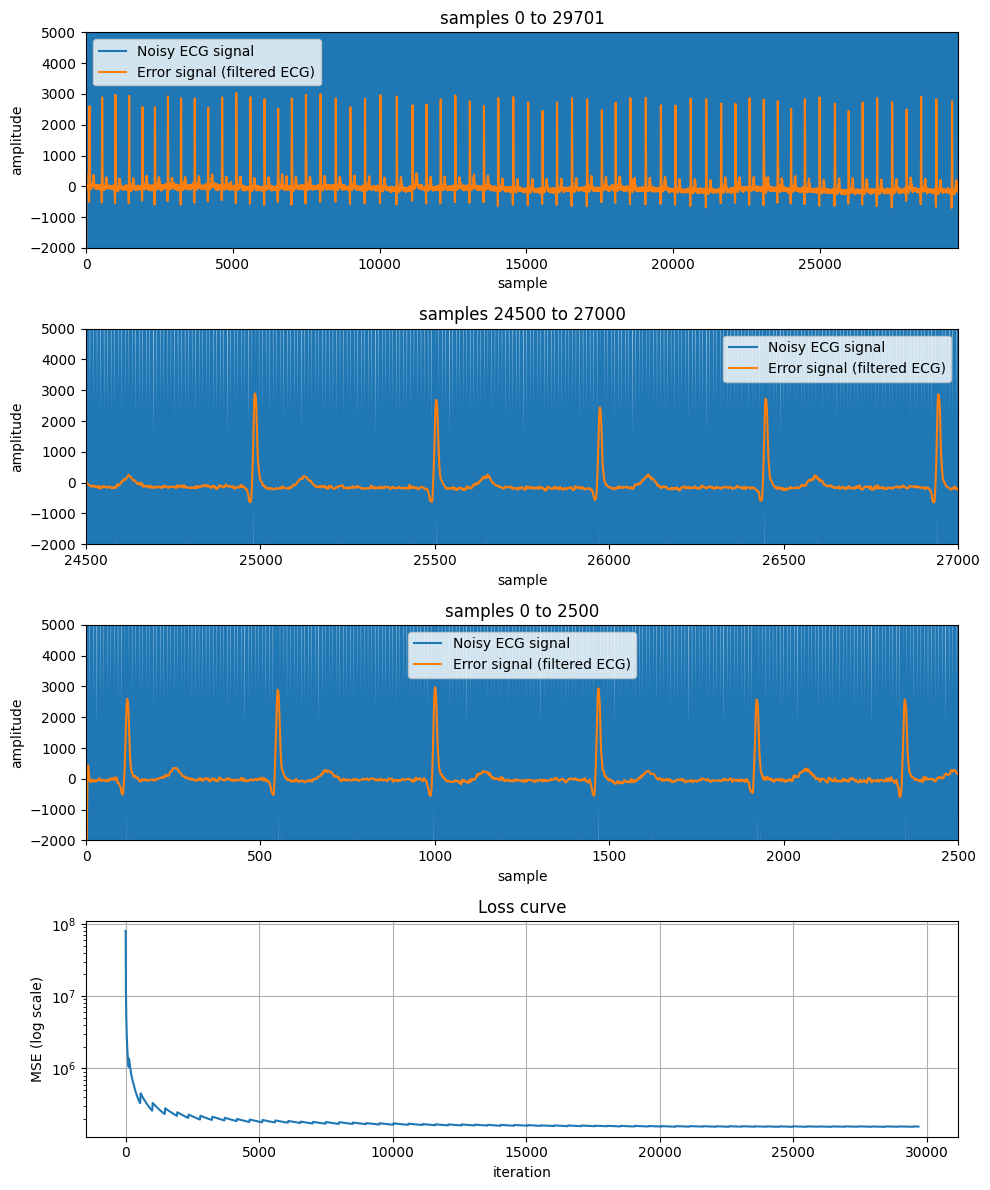

Worst: (6, 0.025486357306136815, -25.855897884939978, 116383.83436804001)


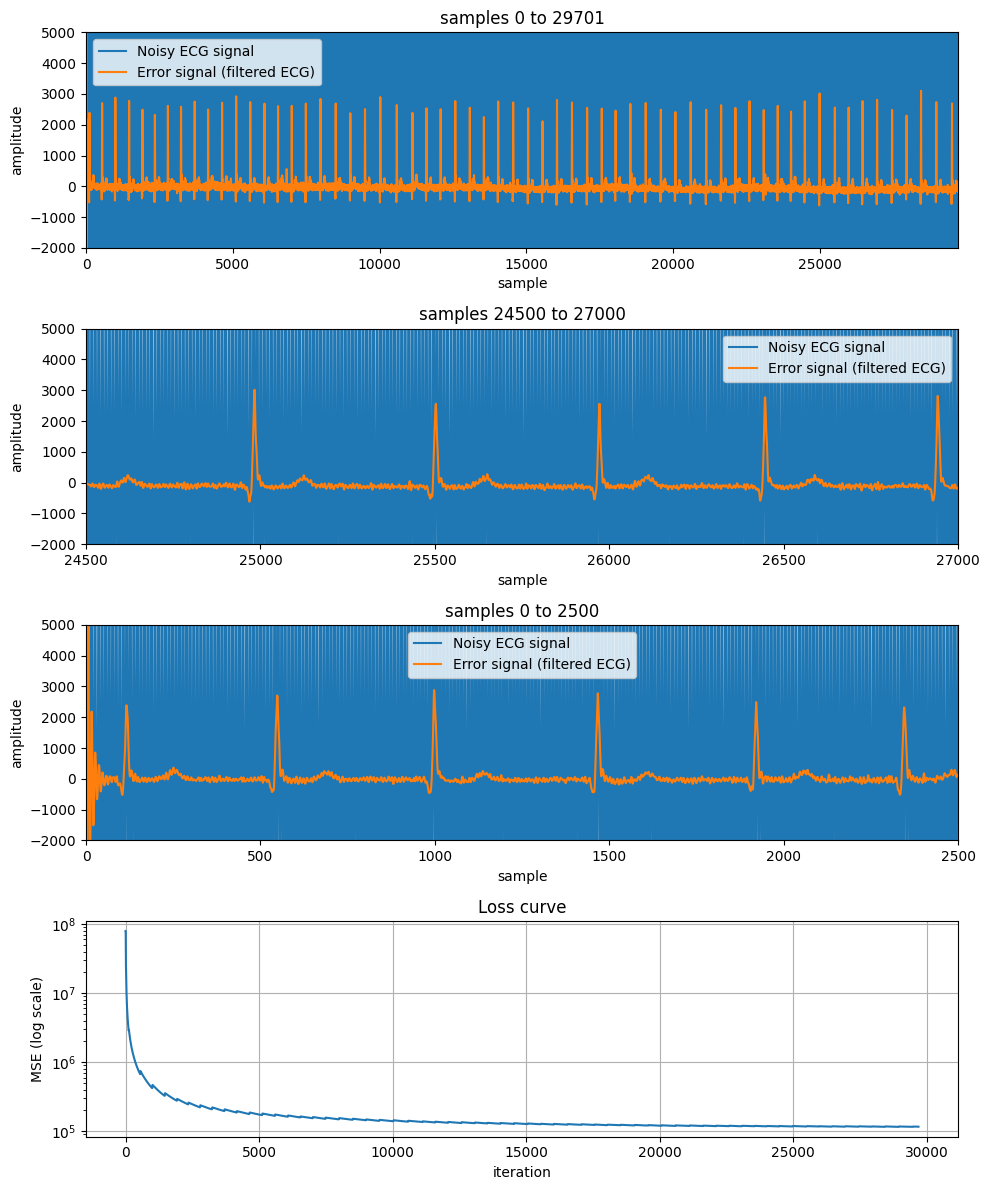

In [40]:
res_lms_best = lms(synthetic_cosine_at_powerline_freq, ecg, mu=best[1], ntaps=best[0])
res_lms_worst = lms(synthetic_cosine_at_powerline_freq, ecg, mu=worst[1], ntaps=worst[0])

print(f'Best: {best}')
plot_filtered_ecg_signal(res_lms_best, savefig='./img/lms_filtered_ecg_signal_best.png')
print(f'Worst: {worst}')
plot_filtered_ecg_signal(res_lms_worst, savefig='./img/lms_filtered_ecg_signal_worst.png')

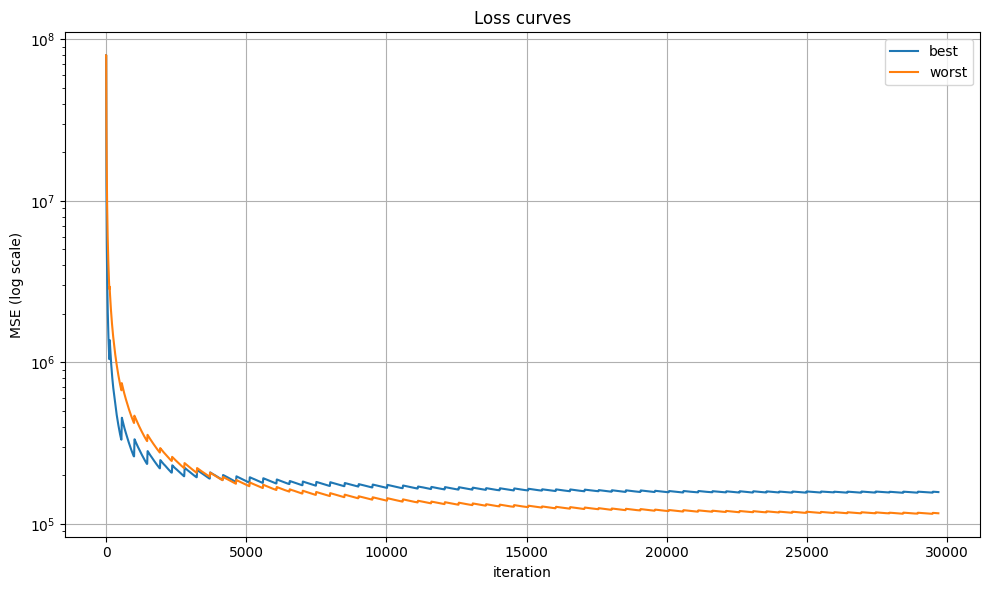

In [41]:
# plot loss curves of best and worst
_, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(res_lms_best.mse, label='best')
ax.plot(res_lms_worst.mse, label='worst')
ax.set_title('Loss curves')
ax.set_xlabel('iteration')
ax.semilogy()
ax.set_ylabel('MSE (log scale)')
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()


---
## Adaptive Line Enhancer

In [54]:
ale_lms_results = []

for delay, taps in tqdm(it.product(np.arange(2,6), np.arange(2, 5)), ncols=100, total=12):
    print(f'delay: {delay}, taps: {taps}')
    ecg_delayed = np.concatenate((np.zeros(delay), ecg[:-delay]))

    _, Rxx = autocorr(ecg, taps)

    # rx = sp.signal.correlate(ecg_delayed[:lags], ecg_delayed[:lags], mode='full')
    # rx = rx[(rx.size//2):] # take only the positive lags
    # rx /= rx[0] # normalize

    # Rxx = sp.linalg.toeplitz(rx[(rx.size // 2):])[:taps, :taps] # take only the positive lags

    # mu = 1 / (3 * np.trace(Rxx)) * 1e-5 # 1e-7 is a magic number that works well, as the step_size needs to be small enough to not diverge
    mu = 1 / (3 * np.trace(Rxx)) * 1e-5 # 1e-7 is a magic number that works well, as the step_size needs to be small enough to not diverge
    print(f'mu: {mu}')
    # result: LmsResult = lms(ecg_delayed, ecg, mu=mu, ntaps=taps)
    result: LmsResult = lms(ecg_delayed, ecg, mu=mu, ntaps=taps)
    err = result.err
    # snr = 10 * np.log10(signaltonoise(err)) # get SNR in dB
    # snr = SNR(err, ecg[:-(taps - 1)] - err)
    snr = SNR(err , estimated_noise)
    ale_lms_results.append((delay, taps, mu, snr))

ale_results_sorted = sorted(ale_lms_results, key=lambda x: x[3], reverse=True)

  0%|                                                                        | 0/12 [00:00<?, ?it/s]

delay: 2, taps: 2
mu: 3.11241674780934e-06


/home/kristoffer/Documents/university/7-semester/advanced-signal-processing/assignments/assignment-2/filters/utils.py:27: RuntimeWarning: overflow encountered in square
  return 10 * np.log10(np.sum(signal**2) / np.sum(noise**2))
  8%|█████▎                                                          | 1/12 [00:01<00:17,  1.59s/it]/home/kristoffer/Documents/university/7-semester/advanced-signal-processing/assignments/assignment-2/filters/LMS.py:66: RuntimeWarning: invalid value encountered in add
  w += mu * 2 * err[i] * x_window


delay: 2, taps: 3
mu: 2.0749444985395597e-06


 17%|██████████▋                                                     | 2/12 [00:03<00:18,  1.83s/it]

delay: 2, taps: 4
mu: 1.55620837390467e-06


 25%|████████████████                                                | 3/12 [00:05<00:15,  1.76s/it]

delay: 3, taps: 2
mu: 3.11241674780934e-06


 33%|█████████████████████▎                                          | 4/12 [00:06<00:13,  1.71s/it]

delay: 3, taps: 3
mu: 2.0749444985395597e-06


 42%|██████████████████████████▋                                     | 5/12 [00:08<00:11,  1.67s/it]

delay: 3, taps: 4
mu: 1.55620837390467e-06


 50%|████████████████████████████████                                | 6/12 [00:10<00:10,  1.69s/it]

delay: 4, taps: 2
mu: 3.11241674780934e-06


 58%|█████████████████████████████████████▎                          | 7/12 [00:11<00:08,  1.68s/it]

delay: 4, taps: 3
mu: 2.0749444985395597e-06


 67%|██████████████████████████████████████████▋                     | 8/12 [00:13<00:06,  1.63s/it]

delay: 4, taps: 4
mu: 1.55620837390467e-06


 75%|████████████████████████████████████████████████                | 9/12 [00:14<00:04,  1.58s/it]

delay: 5, taps: 2
mu: 3.11241674780934e-06


 83%|████████████████████████████████████████████████████▌          | 10/12 [00:16<00:03,  1.64s/it]

delay: 5, taps: 3
mu: 2.0749444985395597e-06


 92%|█████████████████████████████████████████████████████████▊     | 11/12 [00:18<00:01,  1.62s/it]

delay: 5, taps: 4
mu: 1.55620837390467e-06


100%|███████████████████████████████████████████████████████████████| 12/12 [00:19<00:00,  1.64s/it]


In [55]:
df = pd.DataFrame(ale_results_sorted, columns=['delays', 'taps', 'mu', 'snr'])
df.head(10)
# print(np.all(np.isnan(df['snr'])))

,delays,taps,mu,snr
0,2,2,0.000003,NaN
1,2,3,0.000002,NaN
2,2,4,0.000002,NaN
3,3,2,0.000003,NaN
4,3,3,0.000002,NaN
5,3,4,0.000002,NaN
6,4,2,0.000003,NaN
7,4,3,0.000002,NaN
8,4,4,0.000002,NaN
9,5,2,0.000003,NaN


Run with 4 taps and delay = 5


/home/kristoffer/Documents/university/7-semester/advanced-signal-processing/assignments/assignment-2/filters/LMS.py:61: RuntimeWarning: overflow encountered in square
  mse[i] = np.mean(err[:i]**2)
/home/kristoffer/.local/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


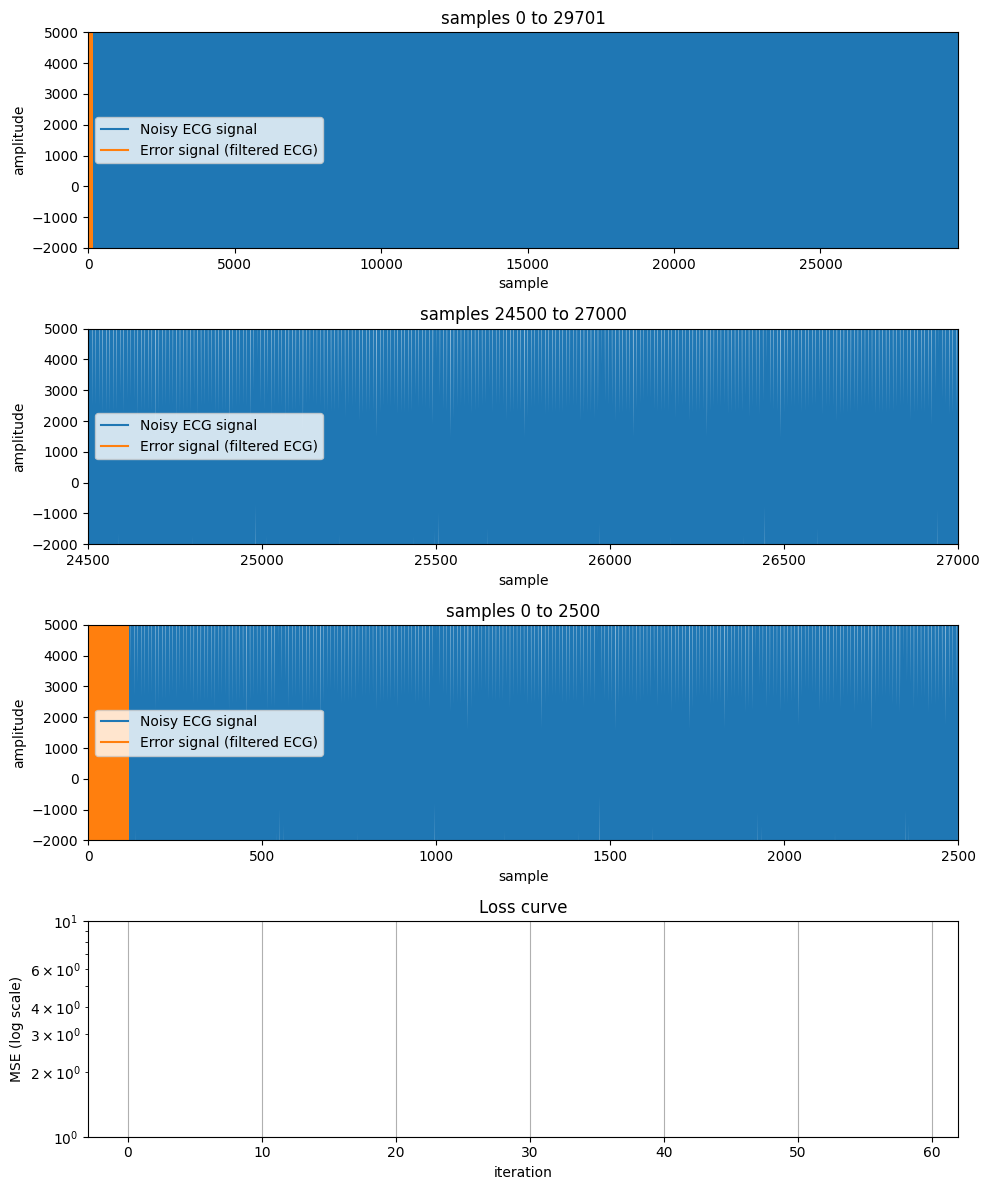

Run with 2 taps and delay = 2


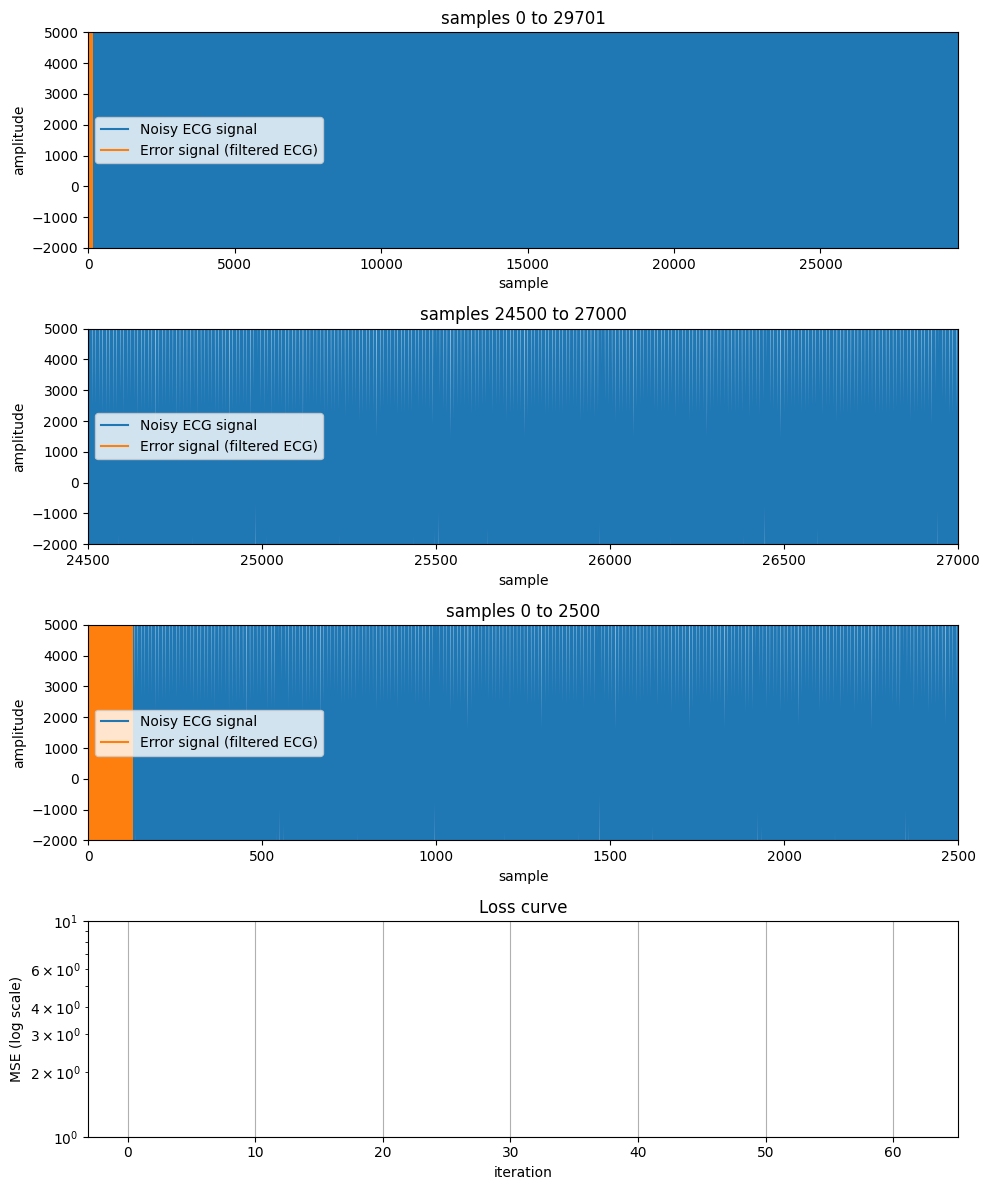

In [56]:
ale_lms_best = ale_results_sorted[0]
ale_lms_worst = ale_results_sorted[-1]

for run in {ale_lms_best, ale_lms_worst}:
    delay, taps, mu, snr = run
    print(f'Run with {taps} taps and delay = {delay}')

    ecg_delayed = np.concatenate((np.zeros(delay), ecg[:-delay]))

    result: LmsResult = lms(ecg_delayed, ecg, mu, taps)

    plot_filtered_ecg_signal(result)

    # xlim_intervals = [(0, n_samples), (0, 2500), (24500, 27000)]
    # plot_loss_curve = True


    # n_plots = len(xlim_intervals)
    # n_plots += 1 if plot_loss_curve else 0

    # _, ax = plt.subplots(n_plots, 1, figsize=(10, 12))

    # err = result.err
    # mse = result.mse
    # y = result.y

    # for i, (xlim_min, xlim_max) in enumerate(xlim_intervals):
    #     ax[i].plot(ecg)
    #     ax[i].plot(y)
    #     # ax[i].plot(err)
    #     ax[i].set_title(f'samples {xlim_min} to {xlim_max}')
    #     ax[i].set_xlabel('sample')
    #     ax[i].set_ylabel('amplitude')
    #     ax[i].set_ylim(-2000, 5000)
    #     ax[i].set_xlim(xlim_min, xlim_max)
    #     ax[i].legend(['Noisy ECG signal', 'Error signal (filtered ECG)'])
        
    # # plot loss curve
    # if plot_loss_curve:
    #     ax[n_plots - 1].plot(mse)
    #     ax[n_plots - 1].set_title('Loss curve')
    #     ax[n_plots - 1].set_xlabel('iteration')
    #     ax[n_plots - 1].semilogy()
    #     ax[n_plots - 1].set_ylabel('MSE (log scale)')
    #     ax[n_plots - 1].grid()

    # plt.tight_layout()
    # plt.show()

---

## Lets try with a NMLS filter instead

In [46]:
from filters.NMLS import nlms, Result as NlmsResult

psi = 0.1
mu = 0.3 # step size between 0 and 1 / (3 * trR)
n_taps = 2

nmls_result: NlmsResult = nlms(synthetic_cosine_at_powerline_freq, ecg, mu=mu, n_taps=n_taps, psi=psi)

/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kristoffer/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [45]:
%%timeit
_: NlmsResult = nlms(synthetic_cosine_at_powerline_freq, ecg, mu=mu, n_taps=n_taps, psi=psi)

NameError: name 'nlms' is not defined

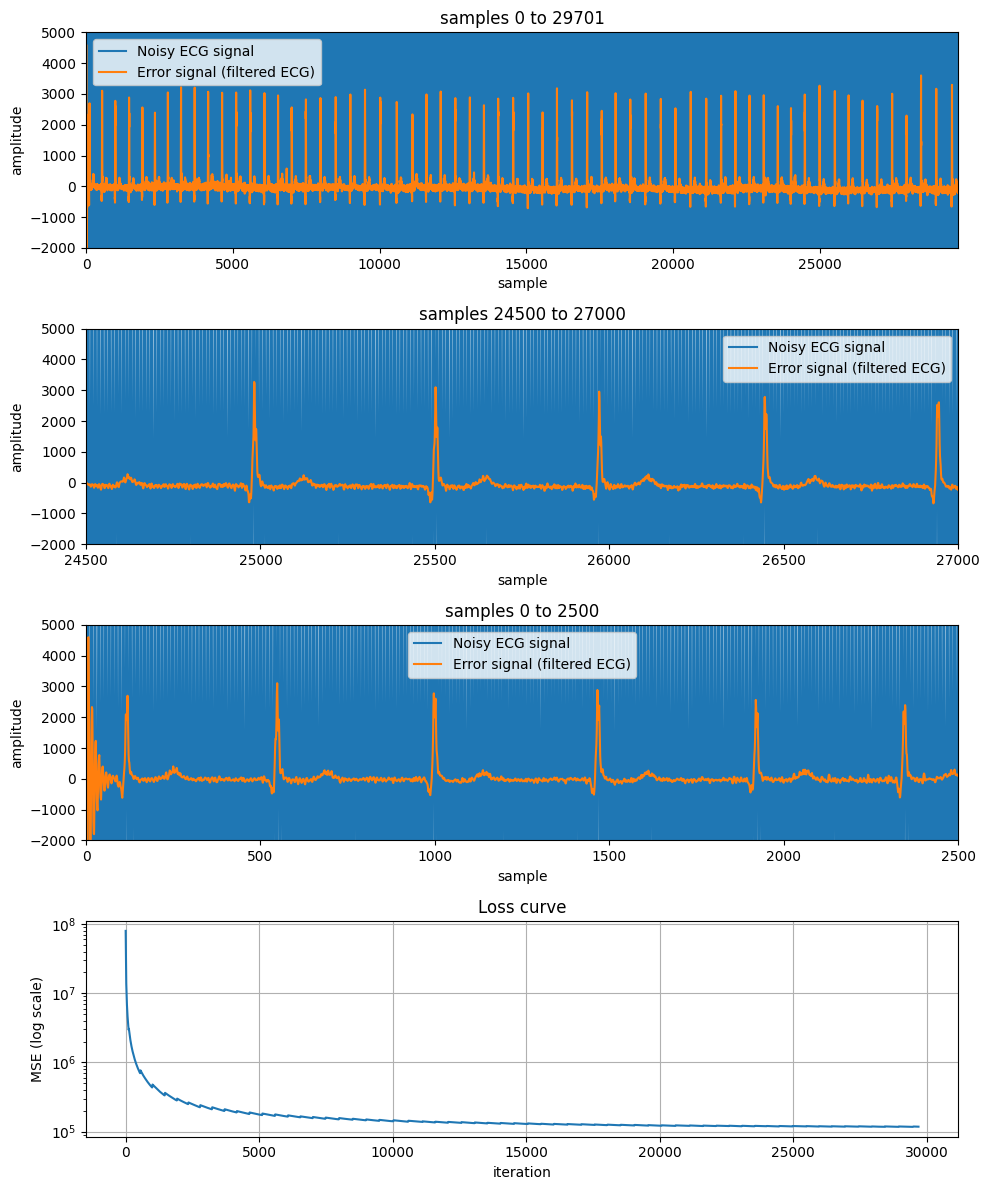

In [ ]:
plot_filtered_ecg_signal(nmls_result)

/tmp/ipykernel_247261/4185467465.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1].scatter(w[:, 0], w[:, 1], cmap=viridis,s=1)


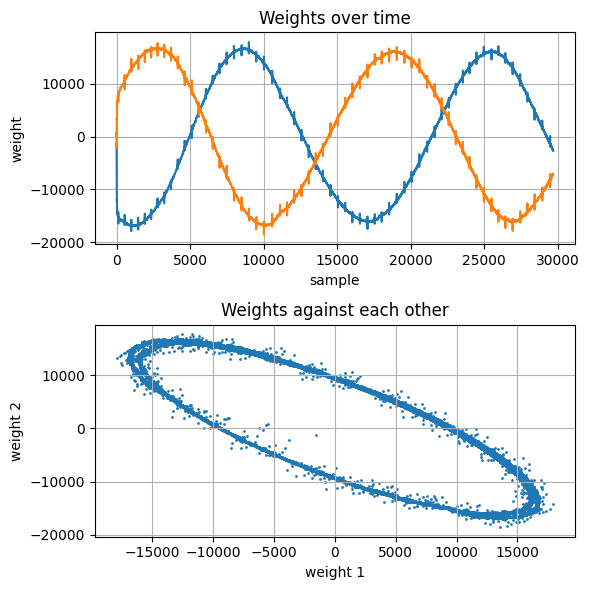

In [ ]:
plot_weights_over_time_and_against_each_other(nmls_result)

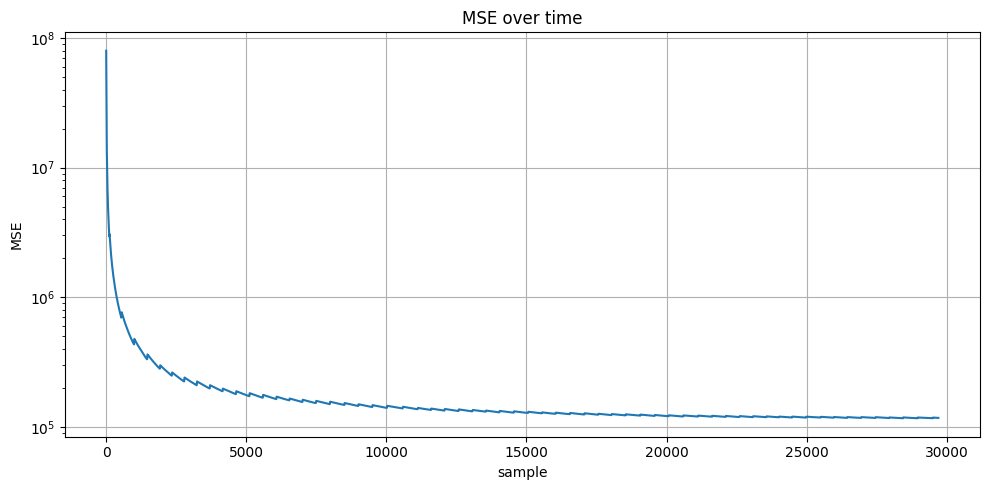

In [ ]:
# plot mse over time
# TODO: is this correct?
# TODO: compare with the mse of the lms

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(nmls_result.mse)
ax.set_title('MSE over time')
ax.set_xlabel('sample')
ax.set_ylabel('MSE')
ax.semilogy()
ax.grid()
plt.tight_layout()
plt.show()


In [ ]:
# from tqdm.notebook import trange, tqdm
# for i in trange(10):
#     time.sleep(0.1)


Interference from a 50 Hz powerline signal is quite common and can in principle also be removed with
a notch filter.

> 10  Design and implement a notch filter. Compare the results with the adaptive solutions.

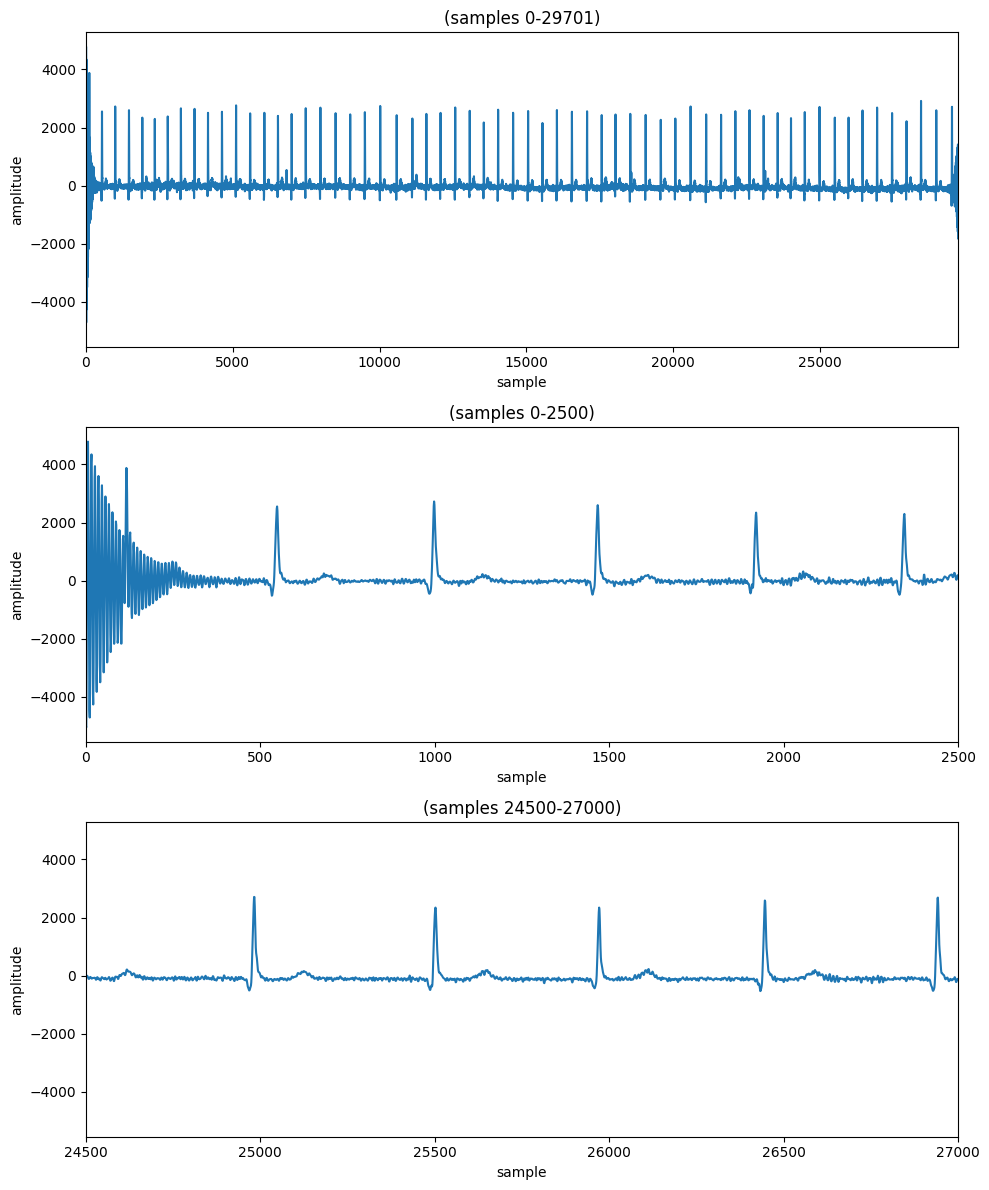

In [ ]:
# Design and apply a 50 Hz notch filter.
Q = 30.0  # Quality factor
b, a = sp.signal.iirnotch(powerline_freq, Q, fs=Fs)
ecg_notch = sp.signal.filtfilt(b, a, ecg)

_, ax = plt.subplots(3, 1, figsize=(10, 12))

for i, (xlim_min, xlim_max) in enumerate([(0, n_samples), (0, 2500), (24500, 27000)]):
    ax[i].plot(ecg_notch)
    ax[i].set_title(f'(samples {xlim_min}-{xlim_max})')
    ax[i].set_xlabel('sample')
    ax[i].set_ylabel('amplitude')
    ax[i].set_xlim(xlim_min, xlim_max)

plt.tight_layout()
plt.show()


In [ ]:
# plot e_lms at 5 taps against ecg_notch

# TODO: compute misadjustment rate for lms filter

## Lets try RLS 

In [ ]:
from filters.RLS import rls, Result as RlsResult



In [ ]:
%%timeit
_: RlsResult = rls(synthetic_cosine_at_powerline_freq, ecg, n_taps=2, forgetting_factor=0.8)

2.99 s ± 295 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
rls_result: RlsResult = rls(synthetic_cosine_at_powerline_freq, ecg, n_taps=2, forgetting_factor=0.8)


In [ ]:
# identification
# f = pa.filters.FilterRLS(n=2, mu=0.1, w="random")
# y, e, w = f.run(d, x)

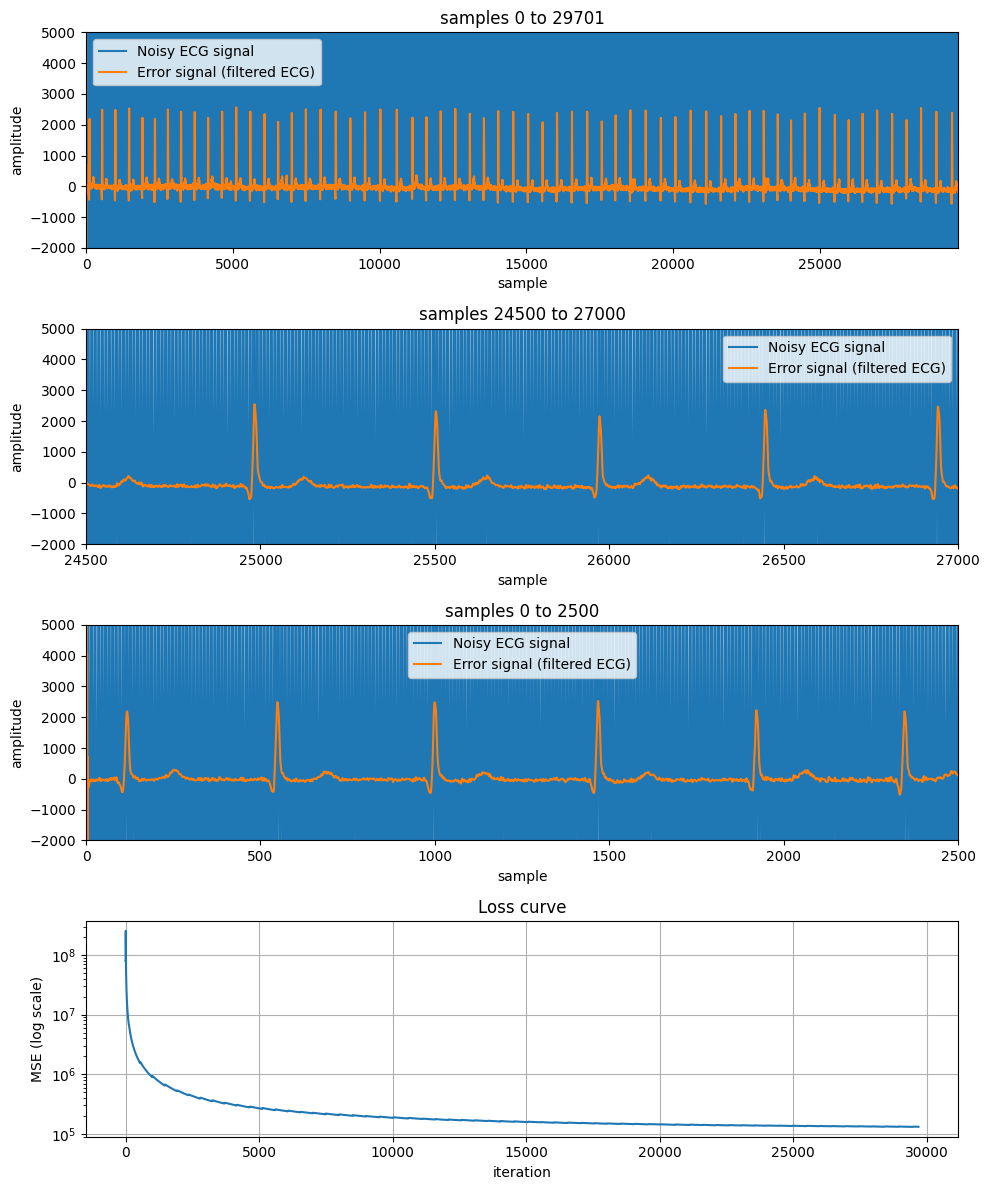

In [ ]:
plot_filtered_ecg_signal(rls_result)

/tmp/ipykernel_247261/4185467465.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1].scatter(w[:, 0], w[:, 1], cmap=viridis,s=1)


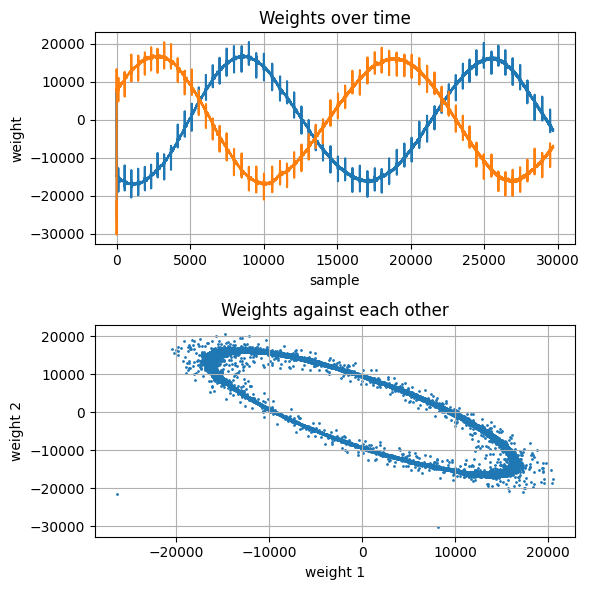

In [ ]:
plot_weights_over_time_and_against_each_other(rls_result)

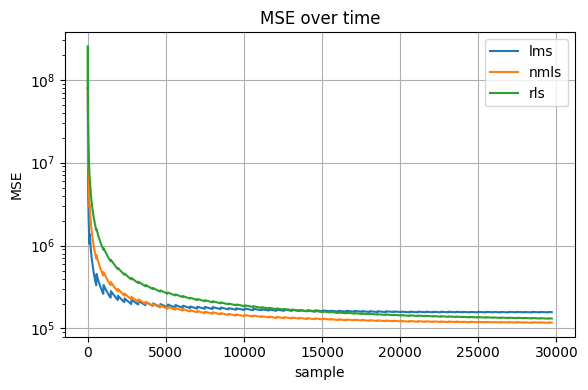

In [ ]:
# compare and plot the mse of the lms, nmls and rls

_, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(res_lms_best.mse, label='lms')
ax.plot(nmls_result.mse, label='nmls')
ax.plot(rls_result.mse, label='rls')
ax.set_title('MSE over time')
ax.set_xlabel('sample')
ax.set_ylabel('MSE')
ax.semilogy()
# ax.set_xlim(0, 1000)
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()
